# Optimization of CNN - TPE

In this notebook, we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [2]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [3]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

In [5]:
import optuna

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [6]:
# Load the data

#data = pd.read_csv("../mnist.csv")
data = pd.read_csv("../data/train.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

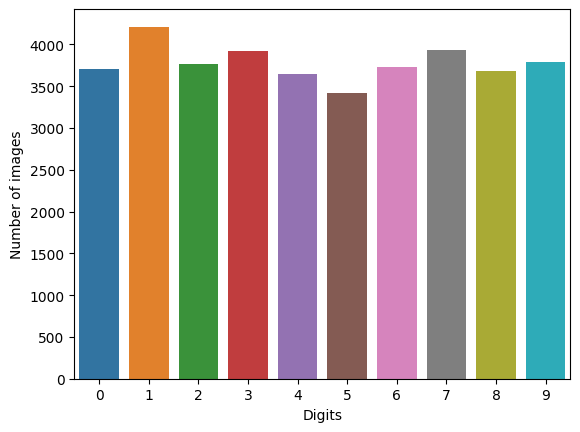

In [9]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [10]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [11]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [12]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [13]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

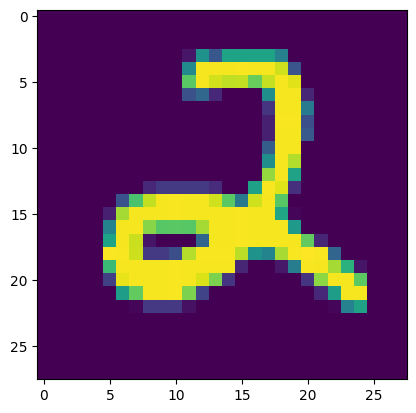

In [14]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

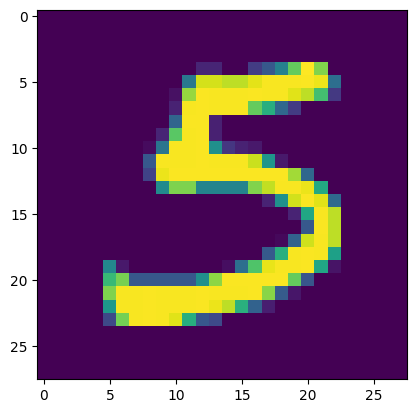

In [15]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [16]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [17]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # NOTE: As per the below configuration, the parameters of each
        # convolutional layer will be identical, even though we draw their
        # values every loop; this is achieved with the name: in each trial,
        # the value of each hyperparameter defined with a name is identical.
        # If we want to have different values in each loop,
        # we should change the name, e.g.:
        #   filters=trial.suggest_categorical(f'filters_{i}', [16, 32, 64])
        #   kernel_size=trial.suggest_categorical(f'kernel_size_{i}', [3, 5])
        #   ...
        
        # if we want different parameters in each layer, check next
        # notebook

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters', [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size', [3, 5]),
            strides=trial.suggest_categorical('strides', [1, 2]),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units', 5, 512),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(lr=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            lr=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128, # this could be another hyperparameter
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return accuracy

In [18]:
# we need this to store the search
# we will use it in the following notebook
# NOTE: if the SQLite database exists, it is loaded
# and the optimization keeps going from the last trial,
# i.e., all the stored trail history is used.
study_name = "cnn_study"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [19]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=10) # 30

[I 2023-05-29 15:06:53,301] Using an existing study with name 'cnn_study' instead of creating a new one.
C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 39s 138ms/step - loss: 0.2550 - accuracy: 0.9197 - val_loss: 0.1022 - val_accuracy: 0.9730
Epoch 2/3
266/266 [==============================] - 36s 134ms/step - loss: 0.0661 - accuracy: 0.9794 - val_loss: 0.0933 - val_accuracy: 0.9733
Epoch 3/3
266/266 [==============================] - 36s 136ms/step - loss: 0.0436 - accuracy: 0.9858 - val_loss: 0.0645 - val_accuracy: 0.9810


[I 2023-05-29 15:08:46,038] Trial 30 finished with value: 0.9809523820877075 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 345, 'optimizer_name': 'Adam', 'learning_rate': 0.0012805159030102203}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 12s 39ms/step - loss: 0.2464 - accuracy: 0.9216 - val_loss: 0.0915 - val_accuracy: 0.9725
Epoch 2/3
266/266 [==============================] - 10s 36ms/step - loss: 0.0657 - accuracy: 0.9792 - val_loss: 0.0707 - val_accuracy: 0.9788
Epoch 3/3
266/266 [==============================] - 10s 36ms/step - loss: 0.0407 - accuracy: 0.9864 - val_loss: 0.0626 - val_accuracy: 0.9810


[I 2023-05-29 15:09:18,705] Trial 31 finished with value: 0.9809523820877075 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 142, 'optimizer_name': 'Adam', 'learning_rate': 0.002251910002019297}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 11s 38ms/step - loss: 0.2082 - accuracy: 0.9338 - val_loss: 0.0790 - val_accuracy: 0.9780
Epoch 2/3
266/266 [==============================] - 11s 40ms/step - loss: 0.0577 - accuracy: 0.9821 - val_loss: 0.0787 - val_accuracy: 0.9772
Epoch 3/3
266/266 [==============================] - 10s 39ms/step - loss: 0.0386 - accuracy: 0.9871 - val_loss: 0.0652 - val_accuracy: 0.9810


[I 2023-05-29 15:09:50,844] Trial 32 finished with value: 0.9809523820877075 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 239, 'optimizer_name': 'Adam', 'learning_rate': 0.0027979743773742373}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 11s 39ms/step - loss: 0.2367 - accuracy: 0.9257 - val_loss: 0.0919 - val_accuracy: 0.9746
Epoch 2/3
266/266 [==============================] - 10s 39ms/step - loss: 0.0609 - accuracy: 0.9812 - val_loss: 0.0752 - val_accuracy: 0.9799
Epoch 3/3
266/266 [==============================] - 10s 38ms/step - loss: 0.0365 - accuracy: 0.9881 - val_loss: 0.0608 - val_accuracy: 0.9815


[I 2023-05-29 15:10:33,189] Trial 33 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 198, 'optimizer_name': 'Adam', 'learning_rate': 0.002088952374320149}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 13s 45ms/step - loss: 0.2338 - accuracy: 0.9263 - val_loss: 0.0911 - val_accuracy: 0.9738
Epoch 2/3
266/266 [==============================] - 12s 46ms/step - loss: 0.0629 - accuracy: 0.9804 - val_loss: 0.0724 - val_accuracy: 0.9786
Epoch 3/3
266/266 [==============================] - 12s 45ms/step - loss: 0.0383 - accuracy: 0.9875 - val_loss: 0.0678 - val_accuracy: 0.9807


[I 2023-05-29 15:11:10,662] Trial 34 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 265, 'optimizer_name': 'Adam', 'learning_rate': 0.0015699156782717004}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 6s 21ms/step - loss: 0.2779 - accuracy: 0.9123 - val_loss: 0.1098 - val_accuracy: 0.9659
Epoch 2/3
266/266 [==============================] - 5s 19ms/step - loss: 0.0812 - accuracy: 0.9748 - val_loss: 0.0979 - val_accuracy: 0.9733
Epoch 3/3
266/266 [==============================] - 4s 17ms/step - loss: 0.0531 - accuracy: 0.9832 - val_loss: 0.0741 - val_accuracy: 0.9765


[I 2023-05-29 15:11:27,039] Trial 35 finished with value: 0.97645503282547 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 58, 'optimizer_name': 'Adam', 'learning_rate': 0.00315314246723081}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3


C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 35s 127ms/step - loss: 0.7908 - accuracy: 0.7478 - val_loss: 0.3699 - val_accuracy: 0.8878
Epoch 2/3
266/266 [==============================] - 37s 139ms/step - loss: 0.3892 - accuracy: 0.8815 - val_loss: 0.4434 - val_accuracy: 0.8714
Epoch 3/3
266/266 [==============================] - 48s 181ms/step - loss: 0.3387 - accuracy: 0.8982 - val_loss: 0.3190 - val_accuracy: 0.9090


[I 2023-05-29 15:13:27,093] Trial 36 finished with value: 0.908994734287262 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 115, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00860426942218261, 'momentum': 0.6327581554987691}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 17s 59ms/step - loss: 0.2046 - accuracy: 0.9353 - val_loss: 0.0846 - val_accuracy: 0.9772
Epoch 2/3
266/266 [==============================] - 15s 57ms/step - loss: 0.0579 - accuracy: 0.9819 - val_loss: 0.0653 - val_accuracy: 0.9802
Epoch 3/3
266/266 [==============================] - 12s 47ms/step - loss: 0.0394 - accuracy: 0.9874 - val_loss: 0.0704 - val_accuracy: 0.9799


[I 2023-05-29 15:14:11,921] Trial 37 finished with value: 0.9798941612243652 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 165, 'optimizer_name': 'Adam', 'learning_rate': 0.0038738586814024614}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 9s 26ms/step - loss: 1.9805 - accuracy: 0.5865 - val_loss: 1.5447 - val_accuracy: 0.7241
Epoch 2/3
266/266 [==============================] - 6s 21ms/step - loss: 1.0894 - accuracy: 0.7844 - val_loss: 0.7637 - val_accuracy: 0.8167
Epoch 3/3
266/266 [==============================] - 5s 20ms/step - loss: 0.5863 - accuracy: 0.8517 - val_loss: 0.4919 - val_accuracy: 0.8664


[I 2023-05-29 15:14:32,774] Trial 38 finished with value: 0.8664020895957947 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 138, 'optimizer_name': 'RMSprop', 'learning_rate': 1.6022595962310836e-05, 'momentum': 0.598885018023152}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 5s 18ms/step - loss: 0.3092 - accuracy: 0.9030 - val_loss: 0.1542 - val_accuracy: 0.9553
Epoch 2/3
266/266 [==============================] - 4s 17ms/step - loss: 0.1357 - accuracy: 0.9580 - val_loss: 0.1579 - val_accuracy: 0.9495
Epoch 3/3
266/266 [==============================] - 5s 18ms/step - loss: 0.1055 - accuracy: 0.9671 - val_loss: 0.1205 - val_accuracy: 0.9648


[I 2023-05-29 15:14:47,946] Trial 39 finished with value: 0.9648148417472839 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 3, 'units': 231, 'optimizer_name': 'Adam', 'learning_rate': 0.0018791060462535576}. Best is trial 12 with value: 0.9838624596595764.


# Analyze results

In [20]:
study.best_params

{'activation': 'relu',
 'filters': 64,
 'kernel_size': 5,
 'learning_rate': 0.0020539678624769604,
 'num_conv_layers': 3,
 'num_dense_layers': 2,
 'optimizer_name': 'Adam',
 'strides': 2,
 'units': 114}

In [21]:
study.best_value

0.9838624596595764

Text(0, 0.5, 'Accuracy')

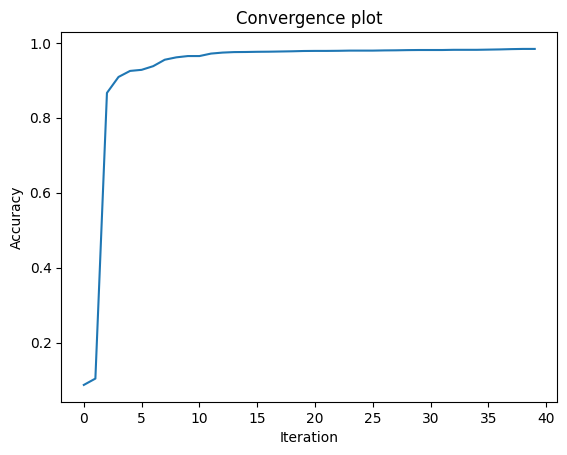

In [22]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Evaluate the model

In [23]:
# load best model
model = load_model(path_best_model)

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dense_9 (Dense)             (None, 198)               621126    
                                                                 
 dense_10 (Dense)            (None, 198)               39402     
                                                                 
 dense_11 (Dense)            (None, 10)                1990      
                                                      

In [25]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 1s 6ms/step - loss: 0.0562 - accuracy: 0.9829


In [26]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.056210048496723175
accuracy 0.9828571677207947


## Confusion matrix

In [27]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 [==============================] - 1s 4ms/step


array([[414,   0,   0,   1,   1,   0,   2,   0,   4,   0],
       [  0, 472,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   2, 403,   0,   0,   0,   1,   1,   2,   0],
       [  0,   0,   1, 417,   0,   4,   0,   1,   3,   0],
       [  1,   3,   0,   0, 424,   0,   1,   0,   0,   0],
       [  0,   0,   0,   2,   0, 375,   3,   0,   2,   0],
       [  0,   0,   0,   0,   1,   0, 411,   0,   0,   0],
       [  0,   2,   4,   1,   1,   1,   0, 457,   2,   1],
       [  0,   1,   0,   0,   0,   0,   3,   0, 380,   0],
       [  2,   1,   0,   1,   9,   0,   1,   2,   3, 375]], dtype=int64)

Text(0.5, 21.34715460257995, 'Predicted label')

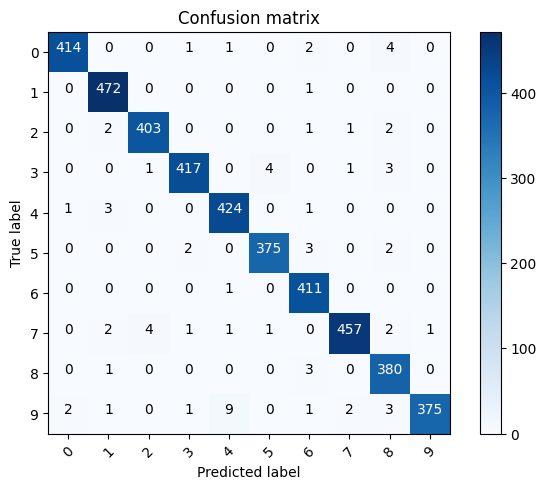

In [28]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.